In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from importlib import reload

Загрузка библиотеки с FCA

In [2]:
import os
import sys
BASE_PATH = os.path.realpath('..')
LIB_DIR = os.path.join(BASE_PATH,'lib')
if LIB_DIR[:-3] not in sys.path:
    sys.path.append(LIB_DIR[:-3])

from lib import fca_interp as fcai

# Load Data

In [3]:
from sklearn.datasets import load_boston

boston_data = load_boston()
boston_ds = pd.DataFrame(boston_data['data'], columns=boston_data['feature_names'])
boston_ds['target'] = boston_data['target']
print(boston_ds.shape)
boston_ds.head()

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [4]:
train_feats = list(boston_ds.drop('target',1).columns)
y_feat = 'target'

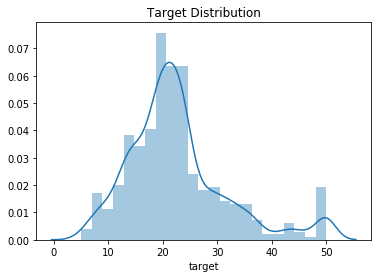

In [5]:
sns.distplot(boston_ds[y_feat])
plt.title('Target Distribution')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,  y_test = train_test_split(boston_ds[train_feats], boston_ds[y_feat], test_size=0.1)
[x.shape for x in [X_train, X_test, y_train,  y_test]]

[(455, 13), (51, 13), (455,), (51,)]

# Check competitors qualities

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [8]:
def calc_metrics(model_name, y_train, y_test, preds_train, preds_test, ds_full=None):
    q_dict = {}
    for metric in [mean_absolute_error, mean_squared_error, r2_score]:
        q_dict[(metric.__name__,"train")] = metric(y_train, preds_train)
        q_dict[(metric.__name__,"test")] = metric(y_test, preds_test)
    q_dict_ = {model_name:q_dict}
    q_dict = q_dict_
    del q_dict_
    q_dict = pd.DataFrame(q_dict).reset_index().rename(columns={'level_0':'metric','level_1':'ds'})
    
    if ds_full is not None:
        if model_name in ds_full.columns:
            ds_full = ds_full.drop(model_name, 1)
        ds_full = ds_full.merge(q_dict, on=['metric','ds'])
    else:
        ds_full = q_dict
    return ds_full

In [9]:
def plot_metrics(ds, figsize=(15,5)):
    plt.figure(figsize=figsize)
    for m_idx, metric in enumerate(ds['metric'].unique()):
        cds = ds[ds['metric']==metric]

        plt.subplot(1,3,m_idx+1)
        for ds_idx, ds_type in enumerate(['train','test']):
            vals = cds[cds['ds']==ds_type].drop(['metric','ds'],1).values[0]
            plt.barh(np.arange(len(vals))+0.3*ds_idx, vals, height=0.3, label=ds_type)
            for v_idx, v in enumerate(vals):
                plt.text(v, v_idx-0.05+0.3*ds_idx, f"{v:.2f}")
        plt.legend(loc='lower left')
        plt.yticks(np.arange(cds.shape[1]-2), cds.drop(['metric','ds'],1).columns, rotation=0)
        plt.title(metric)
    plt.tight_layout()
    plt.show()    

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool


models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(),
          XGBRegressor(), CatBoostRegressor()]
comp_qualities = None
for m in tqdm(models):
    if type(m)==CatBoostRegressor:
        p_train, p_test = Pool(X_train, y_train), Pool(X_test, y_test)
        m.fit(p_train, verbose=False)
        preds_train, preds_test = [m.predict(p) for p in [p_train, p_test]]
    else:
        m.fit(X_train, y_train)
        preds_train, preds_test = [m.predict(p) for p in [X_train, X_test]]
    
    comp_qualities = calc_metrics(m.__class__.__name__, y_train, y_test, preds_train, preds_test, comp_qualities)

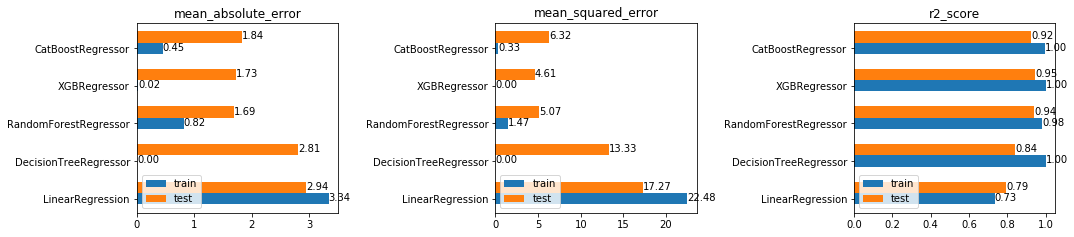

In [11]:
plot_metrics(comp_qualities, figsize=(15,3.4))

# Multi-valued contexts

Работа с узорными структурами.


Сейчас реализованы только:
* интервальная узорная структура ($g^{'} = [a_{min}, a_{max}], \quad g_1^{'}\sqcap g_2^{'} = [min(a_{1_{min}}, a_{2_{min}}), max(a_{1_{max}}, a_{2_{max}}  )],\quad$ где $g$ - объект, $a_{min}, a_{max} \in \mathbb{R}$)
* узорная структура на множествах ($g^{'} = A, \quad g_1^{'}\sqcap g_2^{'} = A_1 \cap A_2,\quad$ где $g$ - объект, $A \subseteq W$,$W$ - множество каких-то значений)

## Lattice construction on big data for supervised learning

На больших контекстах нет смысла рассчитывать все понятия. Будем аппроксимировать решётку через объединение нескольких деревьев решений (про это будет моя магистерская). Возможно такую решётку нельзя будет рассматривать, как средство для KDD (тут лучше пользоваться алгоритмом sofia, который у меня пока не имплементирова), зато её можно использовать для классификации объектов.

### Конструирование аппроксимированной решётки

Делим контекст на обучающую и тестовую выборки.

In [11]:
fcai = reload(fcai)

In [12]:
np.random.seed(42)

mvcntx_train = fcai.MultiValuedContext(X_train, y_true=y_train, cat_attrs=[])
mvcntx_test = fcai.MultiValuedContext(X_test, y_true=y_test, cat_attrs=[])
fm_mv = fcai.FormalManager(mvcntx_train, task_type='Regression')

Строим понятия на обучающей выборке

In [13]:
%%time
fm_mv.construct_concepts(
    use_tqdm=True, algo='RandomForest',
    rf_params={'random_state':42})
print(len(fm_mv.get_concepts()))


29789
CPU times: user 18.5 s, sys: 243 ms, total: 18.8 s
Wall time: 18.6 s


Небольшой костыль - добавляем в решётку самое меньшее понятие, которое ничего не описывает. Это нужно только для красивой визуализации и корректного расчёта индексов стабильности.

In [15]:
fm_mv._concepts.add(
    fcai.PatternStructure(
        extent=[], intent=None, cat_feats=[],
        idx=len(fm_mv.get_concepts()), metrics={'mean_y_true':0} ) )

Строим остовное дерево на понятиях. Для классификации объектов не обязательно рассчитывать всю решётку, все связи между понятиями.

In [16]:
%%time
fm_mv.construct_lattice(use_tqdm=True, only_spanning_tree=True)


CPU times: user 4.81 s, sys: 48.4 ms, total: 4.86 s
Wall time: 4.83 s


Небольшой костыль, чтобы можно было визуализировать получившееся остовное дерево. При расчёте решётки понятий этот код происходит автоматически.

In [17]:
for c in tqdm(fm_mv.get_concepts()):
    c._up_neighbs = {c._up_neighb_st} \
        if c._up_neighb_st is not None else None
    c._low_neighbs = c._low_neighbs_st

fm_mv._calc_concept_levels() # расчёт горизонтальной координаты при отображении понятия

Рассчёт дополнительных метрик для регрессии

Визуализируем остовное дерево

### Классификация с помощью решётки

Алгоритм классификации объекта $g$:
1. Найти множество $C^g$ минимальных (по включению) понятий, которые описывают объект $g$
2. Предсказание для объекта $g$ = среднее из предсказаний каждого понятия из $C^g$

Получаем предсказания для каждого объекта из обучающего и тестового контекстов

In [18]:
%%time
metrics = ['mean_y_true']
preds_train = fm_mv.predict_context(mvcntx_train, metric=metrics)
preds_test = fm_mv.predict_context(mvcntx_test, metric=metrics)
preds_test[[0,10,20]]

CPU times: user 16.6 s, sys: 43.2 ms, total: 16.7 s
Wall time: 16.7 s


matrix([[14.43888865],
        [25.08419068],
        [22.57135789]])

Качество на обучающей и тестовой выборке

In [19]:
comp_qualities = calc_metrics('FCA basic', y_train, y_test, preds_train, preds_test, comp_qualities)

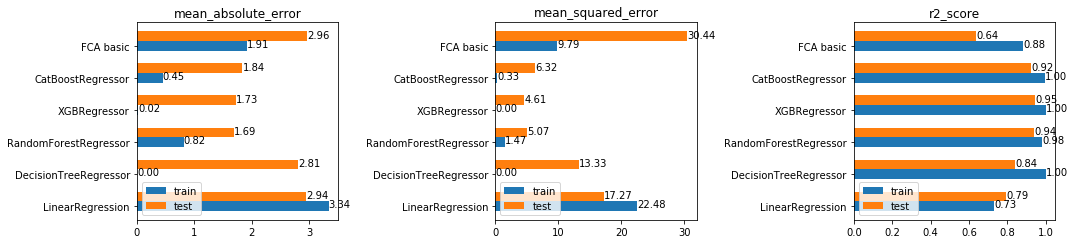

In [20]:
plot_metrics(comp_qualities, (15, 3.5))

# FCA with Linear Regression Weights

In [21]:
def predict_fca(fm, cntx, metric, W, normalized=False, A=None):
    mvals = np.array([c._metrics[metric] for c in fm.sort_concepts()])

    if A is None:
        n_objs, n_cncpts = len(cntx.get_objs()), len(fm.get_concepts())
        
        obj_preds_cncpts = fm.trace_context(cntx)[0]
        
        Acoords = np.array([(1,g, c_id)
                       for g, c_ids in obj_preds_cncpts.items() for c_id in c_ids])
        A = csr_matrix((Acoords[:, 0], (Acoords[:, 1].astype(int), Acoords[:, 2].astype(int))),
                shape=(n_objs, n_cncpts))
    #print(A.shape, mvals.shape)
    Am = A.multiply(mvals)
    
    preds = Am.dot(W)#/(X>0).dot(W) 
    if normalized:
        preds = preds/A.dot(W)
    return preds, A

In [22]:
from scipy.sparse import csr_matrix

In [23]:
def train_rflr(fm, cntx_train, y_train, algo, A_train=None, metric='mean_y_true'):
    n_objs, n_cncpts = len(cntx_train.get_objs()), len(fm.get_concepts())
    W0 =  np.ones(n_cncpts)/n_cncpts
    
    mvals = np.array([c._metrics[metric] for c in fm.sort_concepts()])
    
    if A_train is None:
        n_objs, n_cncpts = len(cntx_train.get_objs()), len(fm.get_concepts())
        
        obj_preds_cncpts = fm.trace_context(cntx_train)[0]
        
        Acoords = np.array([(1,g, c_id)
                       for g, c_ids in obj_preds_cncpts.items() for c_id in c_ids])
        A_train = csr_matrix((Acoords[:, 0], (Acoords[:, 1].astype(int), Acoords[:, 2].astype(int))),
                shape=(n_objs, n_cncpts))
    #print(A.shape, mvals.shape)
    Am = A_train.multiply(mvals)
    
    lr = algo()
    lr.fit(Am, y_train)
    W_lr = lr.coef_
    
    return W_lr

In [24]:
def balance_weights(fm, W):
    W1 = W.copy()
    cncpts_dict = {c.get_id():c for c in fm.get_concepts()}
    for c_idx in range(len(fm.get_concepts())-1,-1,-1):
        if W1[c_idx]==0:
            c = cncpts_dict[c_idx]
            ln_weights = W1[list(c._low_neighbs)]
            W1[c_idx] = ln_weights.mean()
    return W1

In [25]:
from sklearn.linear_model import Ridge

All equal weights

In [26]:
W0 = np.ones(len(fm_mv.get_concepts()))/np.ones(len(fm_mv.get_concepts()))*10

In [27]:
preds_train, A_train = predict_fca(fm_mv, mvcntx_train, 'mean_y_true', W0, normalized=True)
preds_test, A_test = predict_fca(fm_mv, mvcntx_test, 'mean_y_true', W0, normalized=True)
preds_test[np.isnan(preds_test)] = y_train.mean()

comp_qualities = calc_metrics('FCA equal weights norm', y_train, y_test, preds_train, preds_test, comp_qualities)

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning:

invalid value encountered in true_divide



Linear And Ridge Regression Weights

In [28]:
for algo_name, algo in [('LR',LinearRegression), ('Ridge', Ridge)]:
    W = train_rflr(fm_mv, mvcntx_train, y_train, algo, A_train=A_train)
    Wb = balance_weights(fm_mv, W)

    for is_bal_name, w in [('',W), (' balanced',Wb)]:
        preds_train = predict_fca(fm_mv, mvcntx_train, 'mean_y_true', w, normalized=True, A=A_train)[0]
        preds_test = predict_fca(fm_mv, mvcntx_test, 'mean_y_true', w, normalized=True, A=A_test)[0]
        preds_test[np.isnan(preds_test)] = y_train.mean()
        comp_qualities = calc_metrics(
            f'FCA {algo_name}{is_bal_name} norm',
            y_train, y_test, preds_train, preds_test, comp_qualities
        )

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning:

Mean of empty slice.

/root/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning:

invalid value encountered in true_divide

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning:

invalid value encountered in true_divide

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning:

Mean of empty slice.

/root/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning:

invalid value encountered in true_divide

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning:

invalid value encountered in true_divide



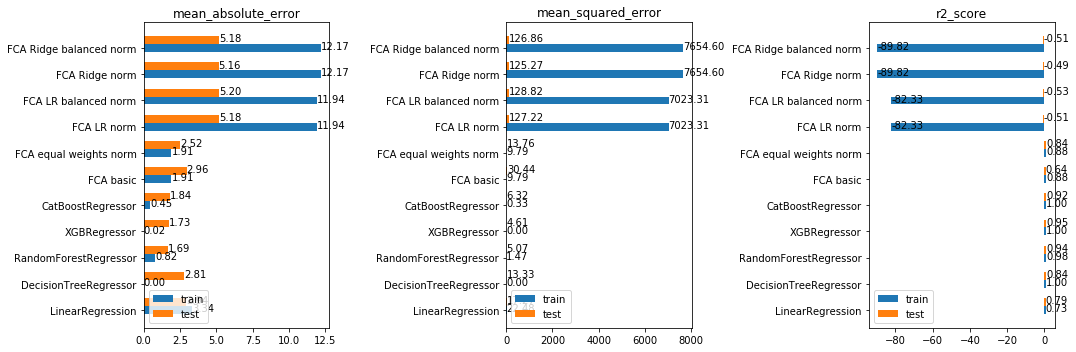

In [29]:
plot_metrics(comp_qualities)

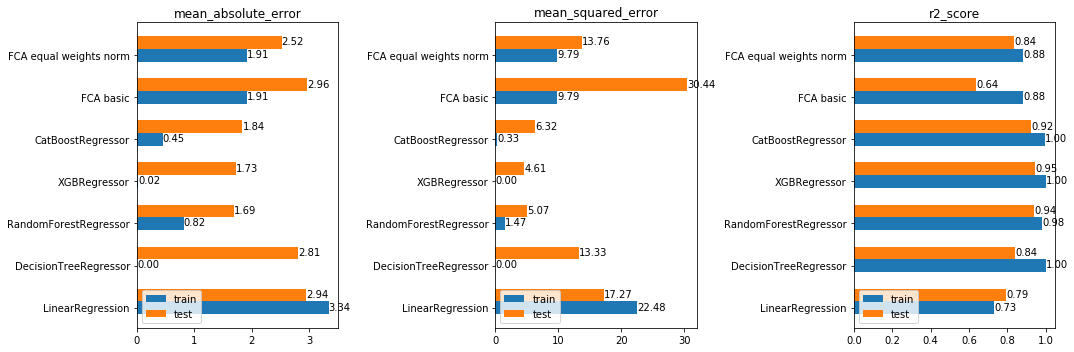

In [30]:
plot_metrics(comp_qualities.drop([f for f in comp_qualities.columns if any([f_ in f for f_ in ['LR','Ridge']])],1))

## Aggregation + Interesting Measures

In [31]:
def predict_fca_top_intermeas(fm, cntx, measure_func, n_top_cncpts, metric='mean_y_true', aggfunc='mean', 
                              obj_preds_cncpts=None):
    wvals = np.array([measure_func(c) for c in fm.sort_concepts()])
    mvals = np.array([c._metrics[metric] for c in fm.sort_concepts()])

    obj_preds_cncpts = fm.trace_context(cntx)[0] if obj_preds_cncpts is None else obj_preds_cncpts
    n_objs, n_cncpts = len(obj_preds_cncpts), len(fm.get_concepts())

    wvals_ths = {g: np.sort(np.unique(wvals[c_ids]))[-n_top_cncpts:].min() if len(c_ids)>0 else None
             for g, c_ids in obj_preds_cncpts.items()}

    if aggfunc == 'mean':
        X_ = np.array([(1,g, c_id)
                       for g, c_ids in obj_preds_cncpts.items()
                       for c_id in c_ids if wvals[c_id]>=wvals_ths[g]])
        X = csr_matrix((X_[:, 0], (X_[:, 1].astype(int), X_[:, 2].astype(int))),
                shape=(n_objs, n_cncpts))
        Xm = X.multiply(mvals)
    
        preds = np.array(Xm.sum(1)/X.sum(1))
    elif aggfunc in ['min','max']:
        dct = {g: [mvals[c_id] for c_id in c_ids if wvals[c_id]>=wvals_ths[g]]
         for g,c_ids in obj_preds_cncpts.items()}
        f_ = min if aggfunc=='min' else max
        preds = np.array([f_(dct[g]) if len(dct[g])>0 else np.nan for g in sorted(dct.keys())]).reshape(-1,1)
    else:
        raise ValueError(f'Unknown aggfunc {aggfunc}. In predict_fca_top_intermeas')
    
    return preds

1 hour to lattice construction

In [45]:
%%time
#approx 5h
fm_mv.construct_lattice(use_tqdm=True, only_spanning_tree=False)


CPU times: user 58min 18s, sys: 9.75 s, total: 58min 28s
Wall time: 58min 21s


In [67]:
for c in tqdm(fm_mv.get_concepts()):
    c._extent = mvcntx_train.get_extent(c.get_intent(), verb=True)

In [68]:
fm_mv.save_concepts_json('concepts30k_boston_ds.json')

In [69]:
fm_mv.calc_stability_approx(use_tqdm=True)

KeyboardInterrupt: 

In [32]:
for c in tqdm(fm_mv.get_concepts()):
    xs = fm_mv.get_context()._y_true[c.get_extent()]
    c._metrics['std_y_true'] = np.nan_to_num(xs.std(ddof=1))
    c._metrics['mae'] = np.abs(xs-xs.mean()).mean()

/root/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

/root/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning:

invalid value encountered in true_divide

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

Mean of empty slice.

/root/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



In [33]:
measure_funcs = {
    'support asc': lambda c: len(c.get_extent()),
    'support desc': lambda c: -len(c.get_extent()),
    'std': lambda c: c._metrics['std_y_true'] if c._metrics['std_y_true']>0 else 1e-9,
    'std inv': lambda c: 1/(1+c._metrics['std_y_true']),
    'std neg': lambda c: -c._metrics['std_y_true'] if c._metrics['std_y_true']>0 else 1e-9,
    'dev': lambda c: c._metrics['std_y_true']**2 if c._metrics['std_y_true']>0 else 1e-9,
    'dev inv': lambda c: 1/(1+c._metrics['std_y_true']**2),
    'dev neg': lambda c: -c._metrics['std_y_true']**2 if c._metrics['std_y_true']>0 else 1e-9,
    'mae': lambda c: c._metrics['mae'] if c._metrics['mae']>0 else 1e-9,
    'mae neg': lambda c: -c._metrics['mae'] if c._metrics['mae']>0 else 1e-9,
    'mae inv': lambda c: 1/(1+c._metrics['mae']),
    #'stability asc': lambda c: fcai.get_not_none(c._metrics['log_stab_min_bound'],0),
    #'stability desc': lambda c: -fcai.get_not_none(c._metrics['log_stab_min_bound'],1),
}

In [34]:
n_max_objects = A_train.sum(0).max() #max([len(c_ids) for g, c_ids in fm_mv.trace_context(mvcntx_train)[0].items()])

In [35]:
import warnings
warnings.filterwarnings("ignore")

In [36]:
%%time
obj_preds_cncpts_train = fm_mv.trace_context(mvcntx_train)[0]
obj_preds_cncpts_test = fm_mv.trace_context(mvcntx_test)[0]

CPU times: user 20.1 s, sys: 23.5 ms, total: 20.1 s
Wall time: 20.1 s


In [37]:
intermeas_qualities = None

for m_func_name, m_func in tqdm(measure_funcs.items()):
    for aggfunc in tqdm(['mean','min','max'], leave=False, desc=m_func_name):
        for n_top_cncpts in tqdm(np.unique(np.linspace(1, n_max_objects, 10).astype(int)), leave=False):
            preds_train = predict_fca_top_intermeas(
                fm_mv, mvcntx_train, m_func, n_top_cncpts,
                aggfunc=aggfunc, obj_preds_cncpts=obj_preds_cncpts_train)
            preds_test = predict_fca_top_intermeas(
                fm_mv, mvcntx_test, m_func, n_top_cncpts,
                aggfunc=aggfunc, obj_preds_cncpts=obj_preds_cncpts_test)
            
            #preds_train = np.nan_to_num(preds_train, nan=fm_mv._top_concept._metrics['mean_y_true'])
            preds_test = np.nan_to_num(preds_test, nan=fm_mv._top_concept._metrics['mean_y_true'])
            
            intermeas_qualities = calc_metrics(
                f"intermeas={m_func_name}_aggfunc={aggfunc}_ncncpts={n_top_cncpts}",
                y_train, y_test, preds_train, preds_test, intermeas_qualities)

In [38]:
cdss= []
for f in intermeas_qualities.drop(['metric','ds'],1).columns:
    cds = intermeas_qualities[['metric','ds',f]].rename(columns={f:'metric_value'})
    cds['type'] = f
    cdss.append(cds)
cds = pd.concat(cdss)
del cdss

In [39]:
cds['interest_measure'] = [x.split('_')[0].split('=')[1] for x in cds['type']]
cds['aggfunc'] = [x.split('_')[1].split('=')[1] for x in cds['type']]
cds['n_top_concepts'] = [int(x.split('_')[2].split('=')[1]) for x in cds['type']]

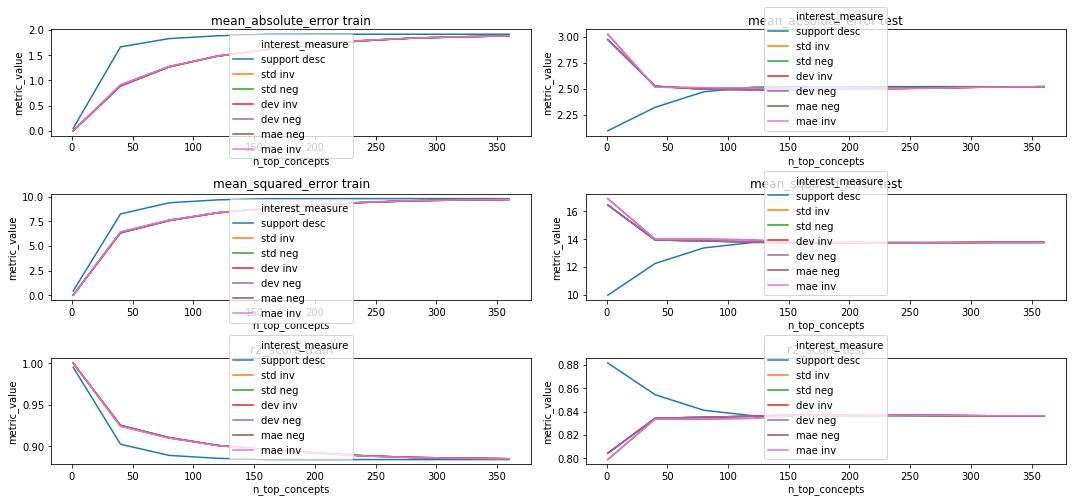

In [40]:
plt.figure(figsize=(15,7))
for m_idx, m in enumerate([m for m in cds['metric'].unique()]):
    for ds_idx, ds_type in enumerate(['train','test']):
        plt.subplot(3,2,m_idx*2+ds_idx+1)
        sns.lineplot(x='n_top_concepts', y='metric_value', hue='interest_measure',
                     data=cds[(cds['aggfunc']=='mean')&(cds['metric']==m)&(cds['ds']==ds_type)&
                             (~cds['interest_measure'].isin(['mae','dev','std','support asc']))]
                    )
        plt.title(f"{m} {ds_type}") 
    
plt.tight_layout()
plt.show()

In [41]:
comp_qualities[['metric','ds','LinearRegression','DecisionTreeRegressor','RandomForestRegressor','XGBRegressor','CatBoostRegressor']]

,metric,ds,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,XGBRegressor,CatBoostRegressor
0,mean_absolute_error,test,2.941801,2.805882,1.686294,1.726681,1.836432
1,mean_absolute_error,train,3.339118,0.000000,0.816688,0.018285,0.447473
2,mean_squared_error,test,17.272005,13.326863,5.074876,4.609389,6.316472
3,mean_squared_error,train,22.477637,0.000000,1.474364,0.000687,0.333439
4,r2_score,test,0.794614,0.841527,0.939653,0.945189,0.924889
5,r2_score,train,0.733298,1.000000,0.982506,0.999992,0.996044


# SAMME approach

In [42]:
fm = fm_mv
cntx = mvcntx_train

In [43]:
Wg = np.ones(len(cntx.get_objs()))/len(cntx.get_objs())
mses = []
for idx in range(20):
    #W = [Wg[c.get_extent()].mean() for c in fm_mv.sort_concepts()]
    W = [np.mean(Wg[c.get_extent()]) for c in fm_mv.sort_concepts()]
    y_pred = predict_fca(fm_mv, mvcntx_train, 'mean_y_true',W, normalized=True, A=A_train)[0]
    
    errv = (y_pred-y_train.values)**2
    Wg = errv/errv.max()
    #err = (Wg*errv).sum()/Wg.sum()
    #alpha = np.log((1-err/errv.max())/(errv/errv.max()))+np.log(len(Wg)-1)
    #Wg = Wg*np.exp(alpha*errv/errv.max())
    #Wg = Wg/Wg.max()
    mses.append(((y_pred-y_train)**2).mean())
    print(f"iter: {idx}, MSE: {mses[-1]}")

iter: 0, MSE: 9.792539311081507
iter: 1, MSE: 6.262474484779947
iter: 2, MSE: 6.186247235169145
iter: 3, MSE: 6.006836231623972
iter: 4, MSE: 5.999541652953375
iter: 5, MSE: 5.975212002643999
iter: 6, MSE: 5.980286471340818
iter: 7, MSE: 5.973541254526728
iter: 8, MSE: 5.976753579344301
iter: 9, MSE: 5.974361056122388
iter: 10, MSE: 5.975719044962135
iter: 11, MSE: 5.9748564377791356
iter: 12, MSE: 5.975359907109173
iter: 13, MSE: 5.975058239921914
iter: 14, MSE: 5.975233611223505
iter: 15, MSE: 5.975131292896818
iter: 16, MSE: 5.975190237427129
iter: 17, MSE: 5.97515634284737
iter: 18, MSE: 5.9751757094838345
iter: 19, MSE: 5.975164673273373


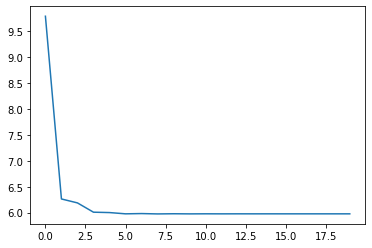

In [44]:
plt.plot(mses)